In [15]:
import numpy as np
import matplotlib.pyplot as plt
from exact_solvers import euler
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim, nn, utils, Tensor
import torch.nn.functional as F
import lightning.pytorch as pl
import mlflow.pytorch
from sklearn.preprocessing import StandardScaler

In [16]:
State = euler.Primitive_State
left_state  = State(Density = 1.0,
                    Velocity = 0.0,
                    Pressure = 0.1)
right_state = State(Density = 3.0,
                    Velocity = 0.0,
                    Pressure = 15.1)

euler.riemann_solution(left_state,right_state)

interactive(children=(FloatSlider(value=0.5, description='t', max=0.9), Dropdown(description='Show characteris…

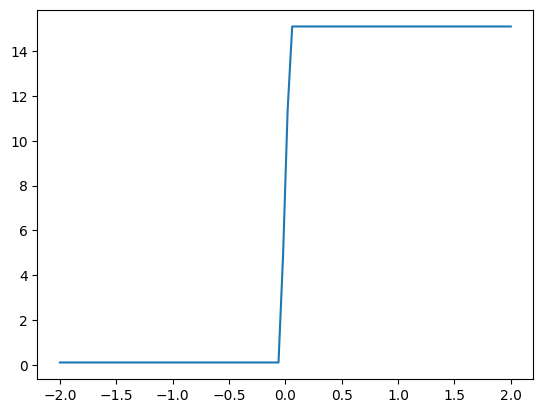

In [17]:
q_l = euler.primitive_to_conservative(*left_state)
q_r = euler.primitive_to_conservative(*right_state)
states, speeds, reval, wave_types = euler.exact_riemann_solution(q_l, q_r, gamma=1.4)

x = np.linspace(-2,2,int(1e2))
P = euler.cons_to_prim(reval(x/0.01))[2]
plt.plot(x,P)

In [18]:
scaler = StandardScaler()

stencil = 5
offset = stencil//2

inputs = []
labels = []

gammas = np.linspace(1.1, 2.0, 10)
times = np.linspace(1e-10, 1.0, 100)
PLs = np.linspace(3, 13, 5)
# PRs = np.linspace(3, 13, 5)
PRs = [0.1]
# grid_sizes = np.power(2, np.arange(6, 12))
grid_sizes = [512]

for gs in grid_sizes:
    print(gs)
    N = gs
    a = -2.0
    b = 2.0

    x = np.linspace(a, b, N)
    dx = (b - a)/N
    
    div = np.zeros(N)
    
    for PL in PLs:
        for PR in PRs:
            left_state  = State(Density = 3.,
                                Velocity = 0.,
                                Pressure = PL)
            right_state = State(Density = 1.,
                                Velocity = 0.,
                                Pressure = PR)
            
            q_l = euler.primitive_to_conservative(*left_state)
            q_r = euler.primitive_to_conservative(*right_state)
            
            
            for gamma in gammas:
            
                states, speeds, reval, wave_types = euler.exact_riemann_solution(q_l, q_r, gamma=gamma)    
                
                for t in times:
                    rho, u, P = euler.cons_to_prim(reval(x/t))

                    if (PL > PR):
                        
                        raref_l, raref_r = speeds[0][0] * t, speeds[0][1] * t
                        contact = speeds[1] * t
                        shock = speeds[2] * t
                    elif (PR > PL):
                        raref_l, raref_r = speeds[2][0] * t, speeds[2][1] * t
                        contact = speeds[1] * t
                        shock = speeds[0] * t
                    else:
                        continue
                
                    div[1:-2] = (u[2:-1] - u[0:-3])/(2 * dx)
                    rho, u, P, div = StandardScaler().fit_transform(rho.reshape(-1,1)).flatten(), StandardScaler().fit_transform(u.reshape(-1,1)).flatten(), StandardScaler().fit_transform(P.reshape(-1,1)).flatten(),StandardScaler().fit_transform(div.reshape(-1,1)).flatten()
                    
                    #shock_loc = np.logical_and(x > (shock - eps),x < (shock + eps))
                    for i in range(offset, N - offset):
                        input = np.zeros((4,stencil))
                        input[0, :] = rho[(i-offset):(i + offset + 1)]
                        #input[0, :] -= np.mean(rho[(i-offset):(i + offset + 1)])
                        input[1, :] = u[(i-offset):(i + offset + 1)]
                        #input[1, :] -= np.mean(u[(i-offset):(i + offset + 1)])
                        input[2, :] = P[(i-offset):(i + offset + 1)]
                        #input[2, :] -= np.mean(P[(i-offset):(i + offset + 1)])
                        input[3, :] = div[(i-offset):(i + offset + 1)]
                        #input[3, :] -= np.mean(div[(i-offset):(i + offset + 1)])
                        inputs.append(input)
                        #if np.any(x[(i-offset):(i + offset + 1)] >= shock) and np.any(x[(i-offset):(i + offset + 1)] <= shock):
                        if np.any(x[(i-offset):(i + offset + 1)] > shock) and np.any(x[(i-offset):(i + offset + 1)] < shock):
                            labels.append(1)
                        else:
                            labels.append(0)
            

# random.seed(42)
# indices_0 = [i for i, label in enumerate(labels) if label == 0]
# indices_1 = [i for i, label in enumerate(labels) if label == 1]

# # Randomly select a subset of 0s with the same size as the number of 1s
# subset_indices_0 = random.sample(indices_0, len(indices_1))

# # Create new balanced lists
# balanced_inputs = [inputs[i] for i in subset_indices_0 + indices_1]
# balanced_labels = [labels[i] for i in subset_indices_0 + indices_1]

512


In [19]:

gammas = np.linspace(1.1, 2.0, 10)
times = np.linspace(1e-10, 1.0, 100)
PRs = np.linspace(3, 13, 5)
# PRs = np.linspace(3, 13, 5)
PLs = [0.1]
#grid_sizes = np.power(2, np.arange(6, 12))
grid_sizes = [512]

for gs in grid_sizes:
    print(gs)
    N = gs
    a = -2.0
    b = 2.0

    x = np.linspace(a, b, N)
    dx = (b - a)/N
    
    div = np.zeros(N)
    
    for PL in PLs:
        for PR in PRs:
            left_state  = State(Density = 1.,
                                Velocity = 0.,
                                Pressure = PL)
            right_state = State(Density = 3.,
                                Velocity = 0.,
                                Pressure = PR)
            
            q_l = euler.primitive_to_conservative(*left_state)
            q_r = euler.primitive_to_conservative(*right_state)
            
            
            for gamma in gammas:
            
                states, speeds, reval, wave_types = euler.exact_riemann_solution(q_l, q_r, gamma=gamma)    
                
                for t in times:
                    rho, u, P = euler.cons_to_prim(reval(x/t))

                    if (PL > PR):
                        
                        raref_l, raref_r = speeds[0][0] * t, speeds[0][1] * t
                        contact = speeds[1] * t
                        shock = speeds[2] * t
                    elif (PR > PL):
                        raref_l, raref_r = speeds[2][0] * t, speeds[2][1] * t
                        contact = speeds[1] * t
                        shock = speeds[0] * t
                    else:
                        continue
                
                    div[1:-2] = (u[2:-1] - u[0:-3])/(2 * dx)
                    rho, u, P, div = StandardScaler().fit_transform(rho.reshape(-1,1)).flatten(), StandardScaler().fit_transform(u.reshape(-1,1)).flatten(), StandardScaler().fit_transform(P.reshape(-1,1)).flatten(),StandardScaler().fit_transform(div.reshape(-1,1)).flatten()

                    
                    #shock_loc = np.logical_and(x > (shock - eps),x < (shock + eps))
                    for i in range(offset, N - offset):
                        input = np.zeros((4,stencil))
                        input[0, :] = rho[(i-offset):(i + offset + 1)]
                        #input[0, :] -= np.mean(rho[(i-offset):(i + offset + 1)])
                        input[1, :] = u[(i-offset):(i + offset + 1)]
                        #input[1, :] -= np.mean(u[(i-offset):(i + offset + 1)])
                        input[2, :] = P[(i-offset):(i + offset + 1)]
                        #input[2, :] -= np.mean(P[(i-offset):(i + offset + 1)])
                        input[3, :] = div[(i-offset):(i + offset + 1)]
                        #input[3, :] -= np.mean(div[(i-offset):(i + offset + 1)])
                        inputs.append(input)
                        #if np.any(x[(i-offset):(i + offset + 1)] >= shock) and np.any(x[(i-offset):(i + offset + 1)] <= shock):
                        if np.any(x[(i-offset):(i + offset + 1)] > shock) and np.any(x[(i-offset):(i + offset + 1)] < shock):
                            labels.append(1)
                        else:
                            labels.append(0)
            

random.seed(42)
indices_0 = [i for i, label in enumerate(labels) if label == 0]
indices_1 = [i for i, label in enumerate(labels) if label == 1]

# Randomly select a subset of 0s with the same size as the number of 1s
subset_indices_0 = random.sample(indices_0, len(indices_1))

# Create new balanced lists
balanced_inputs = [inputs[i] for i in subset_indices_0 + indices_1]
balanced_labels = [labels[i] for i in subset_indices_0 + indices_1]

512


In [ ]:
train_data = []
for i, l in zip(balanced_inputs, balanced_labels):
    train_data.append([torch.tensor(i.flatten(), dtype=torch.float32), torch.tensor(l, dtype=torch.float32)])
    
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]

        # Assuming the first element is the input tensor and the second element is the label tensor
        input_tensor = torch.Tensor(sample[0])
        label_tensor = torch.Tensor(sample[1])

        return input_tensor, label_tensor
        
dataset = CustomDataset(train_data)
seed = torch.Generator().manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=seed)

In [ ]:
torch.save(train_set, "../../../data/ds-2/train_set.pt")
torch.save(valid_set, "../../../data/ds-2/valid_set.pt")
print (len(train_set))
print (len(valid_set))

In [ ]:
class Shock_Cell_Classifier(pl.LightningModule):
    def __init__(self, input_dim, lr = 1e-4, wd = 1.0e-5):
        super().__init__()
        self.save_hyperparameters()

        # self.fc1 = nn.Linear(self.hparams.input_dim, 16)
        # self.fc2 = nn.Linear(16, 2)
        
        self.fc1 = nn.Linear(self.hparams.input_dim, self.hparams.input_dim)
        self.fc2 = nn.Linear(self.hparams.input_dim, 2)
        # self.fc3 = nn.Linear(8, 2)

        self.dropout5 = nn.Dropout(0.50)
        self.dropout2 = nn.Dropout(0.20)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        # nn.init.xavier_uniform_(self.fc3.weight)
        
        #Initialize bias terms to zero
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.constant_(self.fc2.bias, 0)
        # nn.init.constant_(self.fc3.bias, 0)

        self.loss_fn = nn.CrossEntropyLoss()

        # self.logger.log_hyperparams()
    def forward(self, x):
        # x = self.dropout2(x)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout5(x)
        x = self.fc2(x)
        # x = F.leaky_relu(x)
        # x = self.fc3(x)

        return x

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        inputs, labels = batch
        
        output = self.forward(inputs)

        
        loss = self.loss_fn(output, labels.long())
        
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        inputs, labels = batch
        
        output = self.forward(inputs)
        
        val_loss = self.loss_fn(output, labels.long())
        self.log("val_loss", val_loss)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd)
        return optimizer


# init the classifier
classifier = Shock_Cell_Classifier(stencil*4)

In [ ]:
classifier.train()

batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

trainer = pl.Trainer(max_epochs=10,
                     accelerator="cpu")

mlflow.pytorch.autolog()
with mlflow.start_run() as run:
    # mlflow.pytorch.log_model(classifier, "model")
    mlflow.log_params({
            "batch_size": batch_size,
        })
    trainer.fit(model=classifier,
                train_dataloaders=train_loader,
                val_dataloaders=valid_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/henry/euler-nn/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
2024/04/02 07:15:52 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


MissingConfigException: Yaml file '/Users/henry/euler-nn/src/notebooks/nn-02/mlruns/0/meta.yaml' does not exist.

tensor([ 4.9221, 40.7927], grad_fn=<ViewBackward0>)
tensor([ 5.4680, 66.3731], grad_fn=<ViewBackward0>)
tensor([-24.2232,  43.6193], grad_fn=<ViewBackward0>)
tensor([-12.6428,  23.5535], grad_fn=<ViewBackward0>)


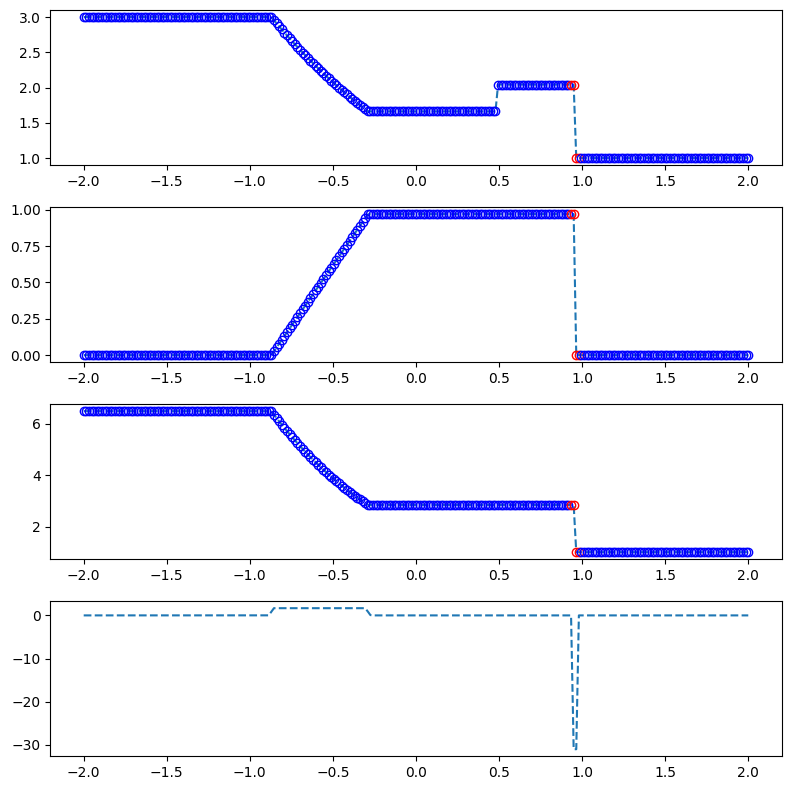

In [ ]:
classifier.eval()
left_state  = State(Density = 3.,
                    Velocity = 0.,
                    Pressure = 6.5)

right_state = State(Density = 1.,
                    Velocity = 0.,
                    Pressure = 1.)
# classifier.eval()
# left_state  = State(Density = 1.,
#                     Velocity = 0.,
#                     Pressure = 1.0)

# right_state = State(Density = 3.,
#                     Velocity = 0.,
#                     Pressure = 8.)

q_l = euler.primitive_to_conservative(*left_state)
q_r = euler.primitive_to_conservative(*right_state)
states, speeds, reval, wave_types = euler.exact_riemann_solution(q_l, q_r, gamma=1.4)

N = 256
a = -2.0
b = 2.0
x = np.linspace(a, b, N)
dx = (b - a)/N

t = 0.5
rho, u, P = euler.cons_to_prim(reval(x/t))
classes = np.zeros(N)
div = np.zeros(N)
div[1:-2] = (u[2:-1] - u[0:-3])/(2 * dx)


for i in range(offset, N-offset):
    input = np.zeros((4,stencil))
    input[0, :] = rho[(i-offset):(i + offset + 1)]
    #input[0, :] -= np.mean(rho[(i-offset):(i + offset + 1)])
    input[1, :] = u[(i-offset):(i + offset + 1)]
    #input[1, :] -= np.mean(u[(i-offset):(i + offset + 1)])
    input[2, :] = P[(i-offset):(i + offset + 1)]
    #input[2, :] -= np.mean(P[(i-offset):(i + offset + 1)])
    input[3, :] = div[(i-offset):(i + offset + 1)]
    #input[3, :] -= np.mean(div[(i-offset):(i + offset + 1)])
    input = input.flatten()
    input = torch.tensor(input, dtype=torch.float32)
    output = classifier(input)
    classes[i] = output.argmax()
    if classes[i] == 1:
        print(output)

fig, axs = plt.subplots(4,1, figsize=(8,8))
axs[0].plot(x, rho, linestyle="--")
axs[1].plot(x, u, linestyle="--")
axs[2].plot(x, P, linestyle="--")
axs[3].plot(x, div, linestyle="--")
for i in range(0, N):
    if (classes[i] == 1):
        axs[0].plot(x[i], rho[i], marker= 'o', markerfacecolor="none", markeredgecolor="red")
        axs[1].plot(x[i], u[i], marker= 'o', markerfacecolor="none", markeredgecolor="red")
        axs[2].plot(x[i], P[i], marker= 'o', markerfacecolor="none", markeredgecolor="red")
    else:
        axs[0].plot(x[i], rho[i], marker='o', markerfacecolor="none", markeredgecolor="blue")
        axs[1].plot(x[i], u[i], marker= 'o', markerfacecolor="none", markeredgecolor="blue")
        axs[2].plot(x[i], P[i], marker= 'o', markerfacecolor="none", markeredgecolor="blue")
plt.tight_layout()
plt.show()

In [ ]:
torch.save(classifier.state_dict(), "../../../models/nn-02/nn-02.pt")

In [ ]:
classifier.to_torchscript("../../../models/nn-02/script-nn-02.pt")

RecursiveScriptModule(
  original_name=Shock_Cell_Classifier
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (dropout5): RecursiveScriptModule(original_name=Dropout)
  (dropout2): RecursiveScriptModule(original_name=Dropout)
  (loss_fn): RecursiveScriptModule(original_name=CrossEntropyLoss)
)

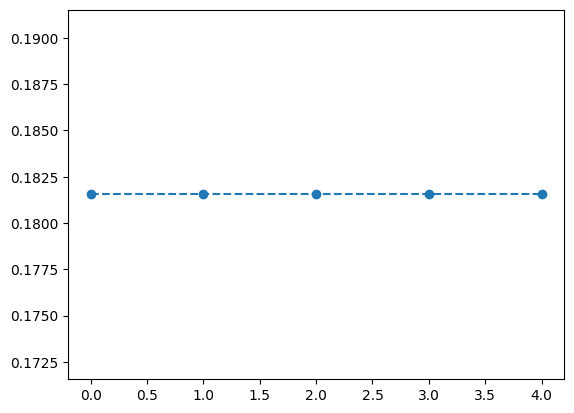

In [ ]:
plt.plot(train_set[9][0][15:20], "--o")

In [ ]:
np.mean(np.array([1,2,3,4]))

2.5

In [ ]:
(1 + 2 + 3 + 4 )/4

2.5

In [ ]:

np.savetxt("./w-b/fc1w.txt", classifier.state_dict()["fc1.weight"].numpy())
np.savetxt("./w-b/fc1b.txt", classifier.state_dict()["fc1.bias"].numpy())
np.savetxt("./w-b/fc2w.txt", classifier.state_dict()["fc2.weight"].numpy())
np.savetxt("./w-b/fc2b.txt", classifier.state_dict()["fc2.bias"].numpy())

In [ ]:
classifier.state_dict()["fc1.weight"].flatten()

tensor([ 0.0253, -0.3653,  0.3094,  0.0466, -0.0676,  0.2963,  0.1487, -0.2058,
         0.4083,  0.6296,  0.6966,  0.5421,  0.5538,  0.1809,  0.4263,  0.0853,
         0.3458,  0.0388, -0.0291, -0.0470,  0.2616, -0.0684,  0.0030,  0.3426,
         0.2544,  0.1549,  0.3189,  0.0103,  0.4042,  0.0848,  0.0222,  0.3176,
         0.4667,  0.1579,  0.4868, -0.3020,  0.2698, -0.0138, -0.0524,  0.0821,
         0.1919,  0.0553, -0.1648,  0.0852,  0.2699, -0.0663, -0.0655, -0.0908,
        -0.0065, -0.1325,  0.6163, -0.1114,  0.3042, -0.0051,  0.4849,  0.2735,
         0.0180, -0.1006,  0.2333, -0.2361,  0.3479, -0.0417, -0.1547, -0.2125,
         0.0319,  0.5915,  0.4554, -0.2243, -0.4019, -0.4178,  0.3088,  0.2389,
         0.3048, -0.2932, -0.4732,  0.0094, -0.3101, -0.3839,  0.0154, -0.2165,
        -0.1975,  0.0763, -0.3393, -0.0691,  0.3110, -0.0701,  0.2376,  0.3713,
        -0.2755, -0.2598, -0.4980, -0.1951,  0.3101,  0.1454,  0.4445, -0.1770,
        -0.3994,  0.0757, -0.4900, -0.32